In [173]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, ConstantScaling
from utils import get_config

from plotting import cart2pol 
# from plotting import scatterplot_variables

from mixing_functions import build_moebius_transform, build_automorphism

In [174]:
# model_root = '/draco/u/vstimper/projects/ica-flows/experiments/triresflow/2d/0300/'
number = '0308'
model_root = '/Users/luigigresele/Desktop/ICA and ICM/Experiments_Vincent/'+ number +'/projects/ica-flows/experiments/triresflow/2d/'+ number +'/'

config = get_config(model_root + 'config/config.yaml')

In [175]:
S_train = jnp.array(jnp.load(model_root + 'data/sources_train.npy'))
S_test = jnp.array(jnp.load(model_root + 'data/sources_test.npy'))
X_train = jnp.array(jnp.load(model_root + 'data/observation_train.npy'))
X_test = jnp.array(jnp.load(model_root + 'data/observation_test.npy'))
mean_std = jnp.load(model_root + 'data/observation_mean_std.npy', allow_pickle=True).item()
mean_train, std_train = mean_std['mean'], mean_std['std']
moeb_params = jnp.load(model_root + 'data/moebius_transform_params.npy', allow_pickle=True).item()

In [176]:
howmany = 5000

S_train = S_train[:howmany]
S_test = S_test[:howmany]
# X_train = X_train[:howmany]
X_test = X_test[:howmany]

In [177]:
jnp.mean(X_train)

DeviceArray(-1.4555455e-08, dtype=float32)

In [178]:
alpha = 1.0
A = jnp.array(moeb_params['A'])
a = jnp.array(moeb_params['a'])
b = jnp.zeros(2) #- jnp.mean(X_train)

mixing_moebius, mixing_moebius_inv = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = jax.vmap(mixing_moebius)

In [179]:
import matplotlib.pyplot as plt

def scatterplot_variables(X, title, colors='None', cmap='hsv', savefig=False,
                          fname="scatterplot", show=True):
    '''
    Scatterplot of 2d variables, can be used both for the mixing and the unmixing
    X : (N,D) array -- N samples, D dimensions (D=2).ss
    '''
    if colors=='None':
        plt.scatter(X[:,0], X[:,1], color='r', s=30)
    else:
        plt.scatter(X[:,0], X[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)
#     if title=="Sources":
#         plt.xlabel('s_1')
#         plt.ylabel('s_2')
#     elif title=="Observations":
#         plt.xlabel('x_1')
#         plt.ylabel('x_2')
#     elif title=="Reconstructed" or title=="Reconstructions":
#         plt.xlabel('y_1')
#         plt.ylabel('y_2')
#     else:
#         plt.xlabel('x-axis')
#         plt.ylabel('y-axis')
#     plt.title(title)
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')
    
#     plt.title('Main title', fontsize=15)
#     if savefig:
#         plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)
#     if show:
#         plt.show()

In [180]:
savefig = False

<ipython-input-181-c437de5b8a59>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
<ipython-input-181-c437de5b8a59>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


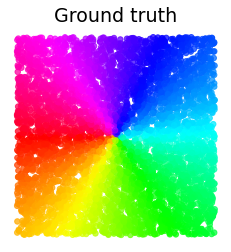

In [181]:
import os

figure_path = "/Users/luigigresele/Documents/Plots_IMA"

import cmocean
cmap = 'hsv'#cmocean.cm.phase

_, colors_train = cart2pol(S_train[:, 0], S_train[:, 1])
_, colors_test = cart2pol(S_test[:, 0], S_test[:, 1])



scatterplot_variables(S_test, 'Sources (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=fname)

fname = os.path.join(figure_path, "true_sources.pdf")

plt.title('Ground truth', fontsize=19)

plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

plt.show()

<ipython-input-182-ac51f23bdd86>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
<ipython-input-182-ac51f23bdd86>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


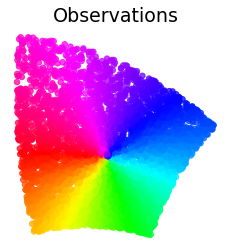

In [182]:
scatterplot_variables(X_test, 'Observations (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "observations.pdf"))

fname = os.path.join(figure_path, "observations.pdf")

plt.title('Observations', fontsize=19)

plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

plt.show()

In [183]:
from jax import vmap

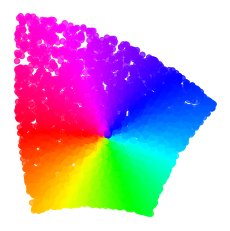

In [184]:
S_test_mixed = vmap(mixing_moebius)(S_test)

scatterplot_variables(S_test_mixed, 'Observations (test)',
                      colors=colors_test, savefig=False, show=True, cmap=cmap)

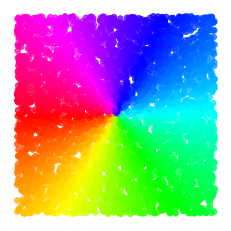

In [185]:
S_test_mixed_unmixed = vmap(mixing_moebius_inv)(S_test_mixed)
scatterplot_variables(S_test_mixed_unmixed, 'Observations (test)',
                      colors=colors_test, savefig=False, show=True, cmap=cmap)

In [186]:
params = hk.data_structures.to_immutable_dict(jnp.load(model_root + 'checkpoints/model_100000.npy', allow_pickle=True).item())

In [187]:
# Setup model
n_layers = config['model']['flow_layers']
hidden_units = config['model']['nn_layers'] * [config['model']['nn_hidden_units']]

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)] + [ConstantScaling(std_train)])
    return flows.inverse(x)

def fw_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)] + [ConstantScaling(std_train)])
    return flows.forward(x)

fw_map = hk.transform(fw_map_fn)
inv_map = hk.transform(inv_map_fn)

<ipython-input-188-4f0d895768ae>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
<ipython-input-188-4f0d895768ae>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


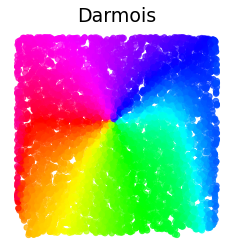

In [188]:
S_rec = inv_map.apply(params, None, X_test)
S_rec_uni = jnp.column_stack([jax.scipy.stats.norm.cdf(S_rec[:, 0]),
                              jax.scipy.stats.norm.cdf(S_rec[:, 1])])
S_rec_uni -= 0.5

scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "darmois.pdf"))

fname = os.path.join(figure_path, "darmois.pdf")

plt.title('Darmois', fontsize=19)

plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

plt.show()

In [189]:
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c, -s], [s, c]])

measure_preserving, measure_preserving_inv = build_automorphism(R)
measure_preserving_batched = jax.vmap(measure_preserving)

<ipython-input-190-5fdee8e49afb>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
<ipython-input-190-5fdee8e49afb>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


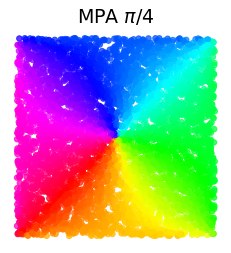

In [190]:
S_ = measure_preserving_batched(S_test + 0.5)

scatterplot_variables(S_, 'Mapped sources (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "mpa.pdf"))

fname = os.path.join(figure_path, "mpa.pdf")

plt.title('MPA $\pi/4$', fontsize=19)

plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

plt.show()

<ipython-input-191-3a7dd2ada57f>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
<ipython-input-191-3a7dd2ada57f>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


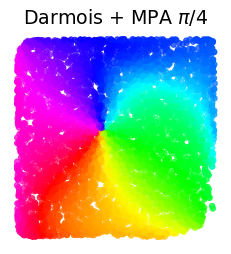

In [191]:
S_rec_uni_ = measure_preserving_batched(S_rec_uni + 0.5)

scatterplot_variables(S_rec_uni_, 'Reconstructed sources (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "mpa_composed_darmois.pdf"))

fname = os.path.join(figure_path, "mpa_composed_darmois.pdf")

plt.title('Darmois + MPA $\pi/4$', fontsize=19)

plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

plt.show()

In [192]:
import numpy as onp
from jax import vmap, jacfwd

In [217]:
from metrics import cima, cima_higher_d

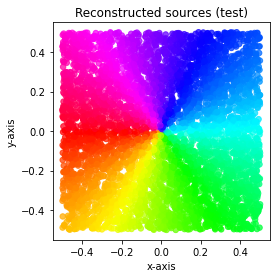

In [22]:
scatterplot_variables(S_test, 'Reconstructed sources (test)',
                      colors=colors_test, savefig=False, show=True, cmap=cmap)

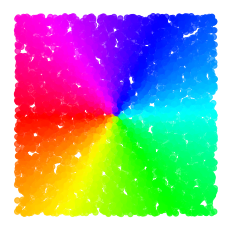

In [215]:
# S_test += 0.5
scatterplot_variables(S_test, 'Reconstructed sources (test)',
                      colors=colors_test, savefig=False, show=True, cmap=cmap)

In [218]:
angles = np.linspace(0, 360, num=720)
cimas_mpa = onp.copy(angles)

for i, angle in enumerate(angles):
    # Build a rotation matrix
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])

    # Build measure pres. automorphism
    measure_preserving, measure_preserving_inv = build_automorphism(R)

#     Map the sources through **direct** mpa
    measure_preserving_batched = vmap(measure_preserving)
    Y = measure_preserving_batched(S_test)
    
#     scatterplot_variables(Y, 'Composed trans', colors=colors_test, savefig=False)#True, fname="observations_flow")
    
    # Compose **its inverse** it with the mixing
    def composed_inverse_transformation(x):
        y = mixing_moebius_inv(x) + 0.5
        return measure_preserving(y)
    comp_inv_batched = jax.vmap(composed_inverse_transformation)
    
    Y_1 = comp_inv_batched(S_test_mixed)
#     print(np.argwhere(np.isnan(Y_1)).shape)
    
#     scatterplot_variables(Y_1, 'Composed trans', colors=colors_test, savefig=False)#True, fname="observations_flow")
    
    # Compute the Jacobian
    Jcomposed = jacfwd(composed_inverse_transformation)
    Jcomposed_batched = vmap(Jcomposed)
    # Compute aDM true
    composed_cima = np.mean(cima(S_test_mixed, Jcomposed_batched))
    cimas_mpa[i] = composed_cima
    

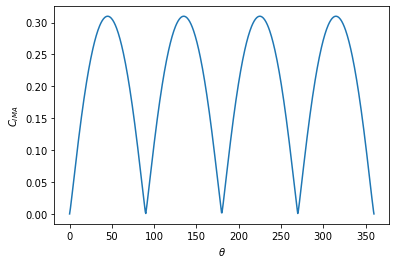

In [219]:
import matplotlib.pyplot as plt
plt.plot(angles, cimas_mpa)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')
plt.show()

In [220]:
# np.save(os.path.join(figure_path,'cima_mpa_0308'), cimas_mpa)#, fmt='%d')

In [212]:
# b = np.load('cima_darmois_mpa_0308.npy')#, dtype=float64)

In [214]:
# np.save(os.path.join(figure_path, 'cima_darmois_mpa_0308'), b)#, fmt='%d')

# Ok, perfect: now let us try to do it with the **composed** transformation

In [133]:
# jac_invmap = jax.vmap(jax.jacfwd())

In [135]:
# jac_invmap(X_test).shape

In [26]:
inv_map_apply = lambda y: inv_map.apply(params, None, y)
jac_invmap = jax.vmap(jax.jacfwd(inv_map_apply))

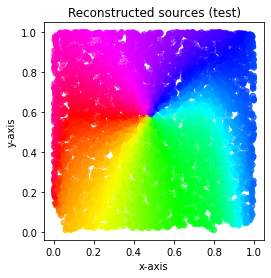

In [30]:
S_rec = inv_map.apply(params, None, X_test)
S_rec_uni = jax.scipy.stats.norm.cdf(S_rec)

scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
                      colors=colors_test, savefig=False, show=True)

In [144]:
jac_invmap(X_test).shape

(5000, 2, 2)

In [68]:
import time

time_0 = time.time()

In [69]:
angles = np.linspace(0, 360, num=720)
cimas = onp.copy(angles)

start = np.copy(time_0)

for i, angle in enumerate(angles):
    # Build a rotation matrix
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])

    # Build measure pres. automorphism
    measure_preserving, measure_preserving_inv = build_automorphism(R)

#     Map the sources through **direct** mpa
    measure_preserving_batched = vmap(measure_preserving)
    Y = measure_preserving_batched(S_rec_uni)
    
#     scatterplot_variables(Y, 'Composed trans', colors=colors_test, savefig=False)#True, fname="observations_flow")
    
    # Compose **its inverse** it with the mixing
    def composed_inverse_transformation(x):
        y = inv_map_apply(x)
        y= jax.scipy.stats.norm.cdf(y)
        return measure_preserving(y)
    comp_inv_batched = vmap(composed_inverse_transformation)
    
    Y_1 = comp_inv_batched(X_test)
#     print(np.argwhere(np.isnan(Y_1)).shape)
    
#     scatterplot_variables(Y_1, 'Back', colors=colors_test, savefig=False)#True, fname="observations_flow")
    
    # Compute the Jacobian
    Jcomposed = jacfwd(composed_inverse_transformation)
    Jcomposed_batched = vmap(Jcomposed)
    # Compute aDM true
    c_cima_ = cima(X_test, Jcomposed_batched)
    composed_cima = np.mean(c_cima_)
    cimas[i] = composed_cima
    if i%5==0:
        stop = time.time()
        print(i, "Duration:", stop - start, "; Total: ", stop - time_0)
        start = time.time()
    

0 Duration: 4.88663911819458 ; Total:  4.88663911819458
5 Duration: 24.245251893997192 ; Total:  29.132097005844116
10 Duration: 25.344367027282715 ; Total:  54.476667165756226
15 Duration: 26.504480123519897 ; Total:  80.98133611679077
20 Duration: 28.891030073165894 ; Total:  109.87347102165222
25 Duration: 28.823829889297485 ; Total:  138.6974880695343
30 Duration: 24.496803283691406 ; Total:  163.19447922706604
35 Duration: 27.17334818840027 ; Total:  190.36797428131104
40 Duration: 27.476161003112793 ; Total:  217.84433507919312
45 Duration: 25.908679008483887 ; Total:  243.7532091140747
50 Duration: 27.428391218185425 ; Total:  271.18178725242615
55 Duration: 25.642290115356445 ; Total:  296.8242201805115
60 Duration: 24.821220874786377 ; Total:  321.6455900669098
65 Duration: 26.310481786727905 ; Total:  347.9562590122223
70 Duration: 27.899593830108643 ; Total:  375.85604190826416
75 Duration: 26.274045944213867 ; Total:  402.1302762031555
80 Duration: 26.212382078170776 ; Tota

In [70]:
cimas.shape

(720,)

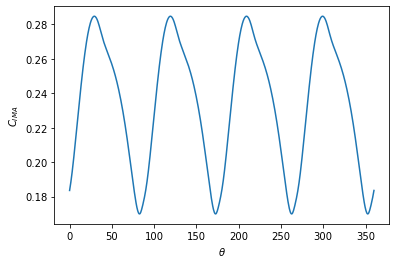

In [71]:
import matplotlib.pyplot as plt
plt.plot(angles, cimas)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')
plt.show()

In [80]:
# np.save('cima_darmois_mpa_0308', cimas)#, fmt='%d')

In [212]:
# b = np.load('cima_darmois_mpa_0308.npy')#, dtype=float64)

In [214]:
# np.save(os.path.join(figure_path, 'cima_darmois_mpa_0308'), b)#, fmt='%d')

In [88]:
angles_rad = np.radians(angles)

### Ci sono delle operazioni ripetute... Il computer fonde se va avanti così.from matplotlib.ticker import FuncFormatter, MultipleLocator


In [108]:
import os

In [109]:
figure_path = "/Users/luigigresele/Documents/Plots_IMA"

In [110]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

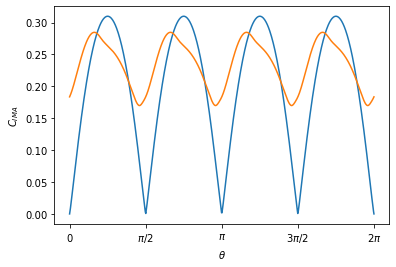

In [111]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(angles_rad, cimas_mpa, label='MPA')
ax.plot(angles_rad, cimas, label='Darmois+MPA')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')

ax.set_xticks(np.arange(0, 2*np.pi+0.01, np.pi/2))
labels = ['$0$', r'$\pi/2$', r'$\pi$',
            r'$3\pi/2$', r'$2\pi$']
ax.set_xticklabels(labels)
# ax.legend(loc='upper right')
plt.savefig(os.path.join(figure_path, 'mpa_darmois.pdf'), 
            dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format=None,
            transparent=True, bbox_inches='tight', pad_inches=0.1, metadata=None)

plt.show()

In [ ]:
x = f(s)

In [ ]:
x = f(mpa(y)), y = mpa^(-1)(s)

In [ ]:
x = f_darmois(z)

In [ ]:
x = f_darmois(mpa(v)), v = mpa^(-1)(z)

# Now plotting the maximum likelihood learned model

In [196]:
# model_root = '/draco/u/vstimper/projects/ica-flows/experiments/triresflow/2d/0300/'
number = '0308_cima/0308/'
model_root = '/Users/luigigresele/Desktop/ICA and ICM/Experiments_Vincent/'+ number #+'/projects/ica-flows/experiments/triresflow/2d/'+ number +'/'

config = get_config(model_root + 'config/config.yaml')

In [197]:
S_train = jnp.array(jnp.load(model_root + 'data/sources_train.npy'))
S_test = jnp.array(jnp.load(model_root + 'data/sources_test.npy'))
X_train = jnp.array(jnp.load(model_root + 'data/observation_train.npy'))
X_test = jnp.array(jnp.load(model_root + 'data/observation_test.npy'))
mean_std = jnp.load(model_root + 'data/observation_mean_std.npy', allow_pickle=True).item()
mean_train, std_train = mean_std['mean'], mean_std['std']
moeb_params = jnp.load(model_root + 'data/moebius_transform_params.npy', allow_pickle=True).item()

In [198]:
howmany = 5000

S_train = S_train[:howmany]
S_test = S_test[:howmany]
# X_train = X_train[:howmany]
X_test = X_test[:howmany]

In [199]:
jnp.mean(X_train)

DeviceArray(-1.4555455e-08, dtype=float32)

In [200]:
alpha = 1.0
A = jnp.array(moeb_params['A'])
a = jnp.array(moeb_params['a'])
b = jnp.zeros(2) #- jnp.mean(X_train)

mixing_moebius, mixing_moebius_inv = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = jax.vmap(mixing_moebius)

In [201]:
# import matplotlib.pyplot as plt

# def scatterplot_variables(X, title, colors='None', cmap='hsv', savefig=False,
#                           fname="scatterplot", show=True):
#     '''
#     Scatterplot of 2d variables, can be used both for the mixing and the unmixing
#     X : (N,D) array -- N samples, D dimensions (D=2).ss
#     '''
#     if colors=='None':
#         plt.scatter(X[:,0], X[:,1], color='r', s=30)
#     else:
#         plt.scatter(X[:,0], X[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)
# #     if title=="Sources":
# #         plt.xlabel('s_1')
# #         plt.ylabel('s_2')
# #     elif title=="Observations":
# #         plt.xlabel('x_1')
# #         plt.ylabel('x_2')
# #     elif title=="Reconstructed" or title=="Reconstructions":
# #         plt.xlabel('y_1')
# #         plt.ylabel('y_2')
# #     else:
# #         plt.xlabel('x-axis')
# #         plt.ylabel('y-axis')
# #     plt.title(title)
#     plt.axis('off')
#     plt.gca().set_aspect('equal', adjustable='box')
#     if savefig:
#         plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)
#     if show:
#         plt.show()

In [202]:
savefig = False

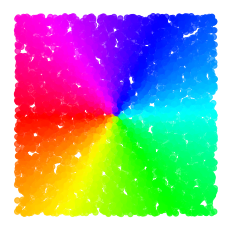

In [203]:
import os

figure_path = "/Users/luigigresele/Documents/Plots_IMA"

import cmocean
cmap = 'hsv'#cmocean.cm.phase

_, colors_train = cart2pol(S_train[:, 0], S_train[:, 1])
_, colors_test = cart2pol(S_test[:, 0], S_test[:, 1])

scatterplot_variables(S_test, 'Sources (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "true_sources.pdf"))



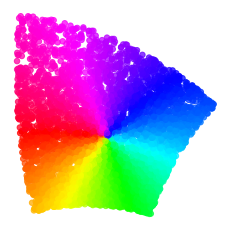

In [204]:
scatterplot_variables(X_test, 'Observations (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "observations.pdf"))

In [205]:
from jax import vmap

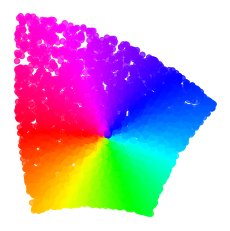

In [206]:
S_test_mixed = vmap(mixing_moebius)(S_test)

scatterplot_variables(S_test_mixed, 'Observations (test)',
                      colors=colors_test, savefig=False, show=True, cmap=cmap)

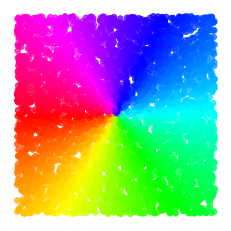

In [207]:
S_test_mixed_unmixed = vmap(mixing_moebius_inv)(S_test_mixed)
scatterplot_variables(S_test_mixed_unmixed, 'Observations (test)',
                      colors=colors_test, savefig=False, show=True, cmap=cmap)

In [208]:
params = hk.data_structures.to_immutable_dict(jnp.load(model_root + 'checkpoints/model_300000.npy', allow_pickle=True).item())

In [209]:
# Setup model
n_layers = config['model']['flow_layers']
hidden_units = config['model']['nn_layers'] * [config['model']['nn_hidden_units']]

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)] + [ConstantScaling(std_train)])
    return flows.inverse(x)

def fw_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)] + [ConstantScaling(std_train)])
    return flows.forward(x)

fw_map = hk.transform(fw_map_fn)
inv_map = hk.transform(inv_map_fn)

In [210]:
savefig = True

<ipython-input-211-ec8449da6a54>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
<ipython-input-211-ec8449da6a54>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


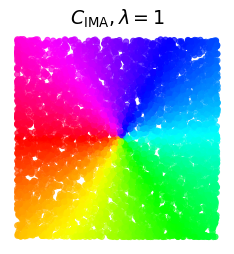

In [211]:
S_rec = inv_map.apply(params, None, X_test)
S_rec_uni = jnp.column_stack([jax.scipy.stats.logistic.cdf(S_rec[:, 0]),
                              jax.scipy.stats.logistic.cdf(S_rec[:, 1])])
S_rec_uni -= 0.5

# scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
#                       colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "darmois.pdf"))

scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "cima_model.pdf"))

fname = os.path.join(figure_path, "cima_model.pdf")

plt.title('$C_{\operatorname{IMA}}, \lambda=1$', fontsize=19)

plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

plt.show()

# perceptually uniform plot
# scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
#                       colors=colors_test, savefig=savefig, show=True, cmap=cmocean.cm.phase, fname=os.path.join(figure_path, "cima_model_percun.pdf"))

# Actually before was lambda=1, **now** plotting the maximum likelihood learned model!

In [221]:
# model_root = '/draco/u/vstimper/projects/ica-flows/experiments/triresflow/2d/0300/'
number = '3308/'
model_root = '/Users/luigigresele/Desktop/ICA and ICM/Experiments_Vincent/'+ number #+'/projects/ica-flows/experiments/triresflow/2d/'+ number +'/'

config = get_config(model_root + 'config/config.yaml')

In [222]:
S_train = jnp.array(jnp.load(model_root + 'data/sources_train.npy'))
S_test = jnp.array(jnp.load(model_root + 'data/sources_test.npy'))
X_train = jnp.array(jnp.load(model_root + 'data/observation_train.npy'))
X_test = jnp.array(jnp.load(model_root + 'data/observation_test.npy'))
mean_std = jnp.load(model_root + 'data/observation_mean_std.npy', allow_pickle=True).item()
mean_train, std_train = mean_std['mean'], mean_std['std']
moeb_params = jnp.load(model_root + 'data/moebius_transform_params.npy', allow_pickle=True).item()

In [223]:
howmany = 5000

S_train = S_train[:howmany]
S_test = S_test[:howmany]
# X_train = X_train[:howmany]
X_test = X_test[:howmany]

In [224]:
jnp.mean(X_train)

DeviceArray(-1.4555455e-08, dtype=float32)

In [225]:
alpha = 1.0
A = jnp.array(moeb_params['A'])
a = jnp.array(moeb_params['a'])
b = jnp.zeros(2) #- jnp.mean(X_train)

mixing_moebius, mixing_moebius_inv = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = jax.vmap(mixing_moebius)

In [226]:
# import matplotlib.pyplot as plt

# def scatterplot_variables(X, title, colors='None', cmap='hsv', savefig=False,
#                           fname="scatterplot", show=True):
#     '''
#     Scatterplot of 2d variables, can be used both for the mixing and the unmixing
#     X : (N,D) array -- N samples, D dimensions (D=2).ss
#     '''
#     if colors=='None':
#         plt.scatter(X[:,0], X[:,1], color='r', s=30)
#     else:
#         plt.scatter(X[:,0], X[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)
# #     if title=="Sources":
# #         plt.xlabel('s_1')
# #         plt.ylabel('s_2')
# #     elif title=="Observations":
# #         plt.xlabel('x_1')
# #         plt.ylabel('x_2')
# #     elif title=="Reconstructed" or title=="Reconstructions":
# #         plt.xlabel('y_1')
# #         plt.ylabel('y_2')
# #     else:
# #         plt.xlabel('x-axis')
# #         plt.ylabel('y-axis')
# #     plt.title(title)
#     plt.axis('off')
#     plt.gca().set_aspect('equal', adjustable='box')
#     if savefig:
#         plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)
#     if show:
#         plt.show()

In [277]:
savefig = True

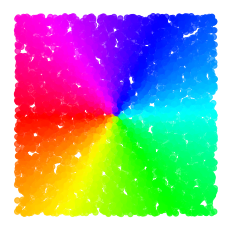

In [228]:
# import os

# figure_path = "/Users/luigigresele/Documents/Plots_IMA"

# import cmocean
# cmap = 'hsv'#cmocean.cm.phase

# _, colors_train = cart2pol(S_train[:, 0], S_train[:, 1])
# _, colors_test = cart2pol(S_test[:, 0], S_test[:, 1])

# scatterplot_variables(S_test, 'Sources (test)',
#                       colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "true_sources.pdf"))



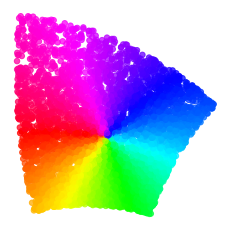

In [229]:
# scatterplot_variables(X_test, 'Observations (test)',
#                       colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "observations.pdf"))

In [230]:
from jax import vmap

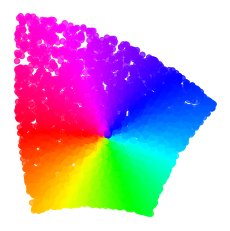

In [231]:
# S_test_mixed = vmap(mixing_moebius)(S_test)

# scatterplot_variables(S_test_mixed, 'Observations (test)',
#                       colors=colors_test, savefig=False, show=True, cmap=cmap)

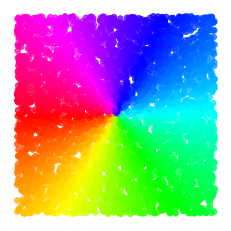

In [232]:
# S_test_mixed_unmixed = vmap(mixing_moebius_inv)(S_test_mixed)
# scatterplot_variables(S_test_mixed_unmixed, 'Observations (test)',
#                       colors=colors_test, savefig=False, show=True, cmap=cmap)

<ipython-input-278-3bba3c002f88>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
<ipython-input-278-3bba3c002f88>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


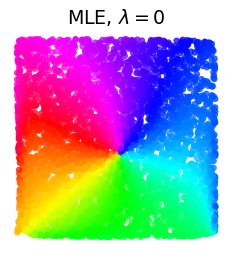

In [278]:
params = hk.data_structures.to_immutable_dict(jnp.load(model_root + 'checkpoints/model_280000.npy', allow_pickle=True).item())

# Setup model
n_layers = config['model']['flow_layers']
hidden_units = config['model']['nn_layers'] * [config['model']['nn_hidden_units']]

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)] + [ConstantScaling(std_train)])
    return flows.inverse(x)

def fw_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)] + [ConstantScaling(std_train)])
    return flows.forward(x)

fw_map = hk.transform(fw_map_fn)
inv_map = hk.transform(inv_map_fn)

savefig = False

S_rec = inv_map.apply(params, None, X_test)
S_rec_uni = jnp.column_stack([jax.scipy.stats.logistic.cdf(S_rec[:, 0]),
                              jax.scipy.stats.logistic.cdf(S_rec[:, 1])])
S_rec_uni -= 0.5

# scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
#                       colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "darmois.pdf"))

scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
                      colors=colors_test, savefig=savefig, show=True, cmap=cmap, fname=os.path.join(figure_path, "mle.pdf"))

fname = os.path.join(figure_path, "mle.pdf")

plt.title('MLE, $\lambda=0$', fontsize=19)

plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None)

plt.show()

# perceptually uniform plot
# scatterplot_variables(S_rec_uni, 'Reconstructed sources (test)',
#                       colors=colors_test, savefig=savefig, show=True, cmap=cmocean.cm.phase, fname=os.path.join(figure_path, "cima_model_percun.pdf"))

In [ ]:
loss = np.load()

In [251]:
import pandas as pd

loss_path = os.path.join(model_root, 'log/loss.csv')

data = pd.read_csv (loss_path)   
# df = pd.DataFrame(data, columns= ['Client Name','Country'])
print (data['loss'])

-2.184319972991944


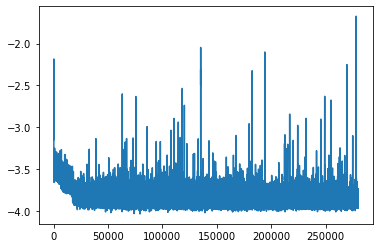

In [256]:
plt.plot(data['loss'][0:280000])
plt.show()

In [259]:
np.min(data['loss'])

-4.035362243652344

In [275]:
data['loss'][200000:260000]

200000   -3.884078
200001   -3.912149
200002   -3.865769
200003   -3.843969
200004   -3.839262
            ...   
259995   -3.867543
259996   -3.882561
259997   -3.892119
259998   -3.869002
259999   -3.925083
Name: loss, Length: 60000, dtype: float64

In [269]:
data['loss'][275000]

-3.774404764175415